# SA CCR - Mapping instruments to parameters (Effective Notional and MtM)

**Introduction:<br>**
This notebook contains the methods for calculating the effective notional of transactions and MtM as defined in the SA CCR methodology for the determination of counterparty credit risk capital requirements. SA CCR was introduced in 2014 and phased in by January 2017 as part of the Basel III framework. It replaced Basel I Current Exposure Method (CEM) and Basels II Standardized Method (SM).<br>


<u>Source</u> : https://www.bis.org/basel_framework/chapter/CRE/52.htm?inforce=20230101&published=20200605#paragraph_CRE_52_20230101_52_24


**Model Summary:<br>**

At a high level interpretation, the SA CCR methodology can be broken down into the following steps :
- A top down allocation of instruments to corresponding {Asset Class x Hedging Set x Bucket} category:
    - Netting set -> Asset Class -> Hedging Set -> Bucket -> instrument
- Mapping of instruments to the parameters required to calculate the Effective Notional of the instrument (more or less delta sensitity to underlying RF):
    -  instrument -> instrument parameters -> Effective Notional of transaction
- A bottom up aggregation of instrument Effective Notionals to obtain the netting set EAD:
    - Effective Notional of instrument -> Bucket -> Hedging Set -> Asset Class -> Netting set
    
<br>
This Notebook concerns itself with the second step: mapping instruments into the parameters required for aggreation. A separate notebook will implement the top down allocation (step 1) and the bottom up aggregation (step 3) of a portfolio of instruments. 


**Author:** <br>
This Notebook (implementation and analysis) is the work and property of Joshua KAJI - FRM. All Rights reserved.

**Structure of the document:**<br>
The notebook is structured to facilitate comprehension of the methodology, both in terms of implementation and description. Each code cell is preceded by an explanatory note outlining the tasks undertaken, as well as the subsection reference (eg: CRE52.XX) to which it relates in the regulatory documentation.

**Table of Content:**
1) [Brief overview of the SA CCR methodology and instrument parameters required for compuation EAD for each netting set](#section1)<br>
    1.1 [EAD as a function of current exposure (RC) and potential future exposure (PFE)](#section2)<br>
    1.2 [General steps followed for computing AddOn(asset class)](#section3)<br>
    1.3 [defining a intrument superclass class with general attributes and methods to asset class specific instruments](#section4)<br>
2) [IR instruments](#section5)<br>
    2.1 [Swap](#section6)<br>
    2.2 [Forward Swap](#section7)<br>
    2.3 [Swaption](#section8)<br>
3) [FX instruments](#section9)<br>
    3.1 [FX Forward](#section10)<br>
    3.2 [FX Call](#section11)<br>
4) [Equity instruments](#section12)<br>
    4.1 [Equity Call](#section13)<br>

## <a id="section1"></a> 1) Brief overview of the SA CCR methodology and instrument parameters required for compuation EAD for each netting set

### <a id="section2"></a>EAD as a function of current exposure (RC) and potential future exposure (PFE)
The purpose of SA CCR is to determine the EAD for each netting set. The formula applied is the following.
<br><br>
<details>
  <summary>[52.1] : EAD requires computation of Replacement cost (RC) and potential future exposure (PFE) </summary>
  <img src="screenshots/52.1.png" alt="image"  width="600" />
</details>

<u>Note</u>: the alpha parameter is applied to account for model inacuracies. Litterature outside of BCBS documentation indicate that it accounts (in part) for wrong way risk (wrong way risk). Mathematically, WWR is the positive correlation between the default of a counterparty (PD) and the exposure (EAD) that the bank has with that counterparty (ie : when the counterparty expriences downgrade, the exposure tends to be higher). Typical examples of WWR include long credit protection (CDS) with a counterparty whose default is correlated to the underlying entity.
<br><br>

<details>
  <summary>[52.10] : Replacement Cost (RC) for unmargined transactions </summary>
  <img src="screenshots/52.10.png" alt="image"  width="600" />
</details>

<details>
  <summary>[52.18] : Replacement Cost (RC) for margined transactions </summary>
  <img src="screenshots/52.18.png" alt="image"  width="600" />
</details>

In the formula of the replacement cost for both margined and unmargined transactions, the current value of positions held with the counterparty must be evaluated. In the definition of our instrument class, we must therefore include the means to calculate the mark to market (MtM) value of the trade.
<br><br>
<details>
  <summary>[52.20] : PFE potential Future Exposure </summary>
  <img src="screenshots/52.20.png" alt="image"  width="600" />
</details>

The multiplier takes into account excess colateral by scaling down the PFE when the portfolio value (V-C) is negative via the formula below. 
<br><br>
<details>
  <summary>[52.23] : multiplier depends on V, C, and aggregated Add On </summary>
  <img src="screenshots/52.23.png" alt="image"  width="600" />
</details>

The aggregate add on is the sum of add ons calculated for each of the 5 asset classes: IR, FX, Equity, Credit, Commodity

<details>
  <summary>[52.25] : aggregate add on formula </summary>
  <img src="screenshots/52.25.png" alt="image"  width="600" />
</details>

### <a id="section3"></a> General steps followed for computing AddOn(asset class)
<br>
<details>
  <summary>[52.30] : general steps for the calculation of asset class level add on (common to all asset classes) </summary>
  <img src="screenshots/52.30.png" alt="image"  width="600" />
</details>

<u>key takaways of [52.30] regarding trade parameter inputs:</u>
- For each transaction, we must determine the effective notional of the trade Di via the following formula:<br>
Di = di * MFi * δi (for intrument i)
Di represents the 1st order sensitivity of a transaction to movements of the underlying risk factors.
    - di : The effective notional di represents the size of the transaction. For IR derivatives, the effective notional takes into account the duration of the underlying referenced by the derivative (via Si, Ei : start and end dates of the referenced IR underlying).
    - δi : The supervisory delta represents the direction of the trade (long vs short) and non linear aspects that come from optionality.<br>
The parameters required to compute δi depend on the instrument type: 
        - for linear instruments: δi = 1 for long positions and -1 for short positions 
        - for instruments with optionality ([52.40]):  
            - S : the spot of the underlying 
            - K : the strike of the option
            - σ : the supervisory volatility provided by the regulator via table [52.72]
            - T : the exercise maturity date
        - for CDO tranches ([52.41]):
            - Ai : attachment point of the tranch 
            - Di : detachement point of the tranch 
    - MFi : The Maturity factor MF which depends on the netting agreement:
        - for unmargined netting sets, the formula is provided in [52.48] and depends on the maturity Mi of the instrument 
        - for margined netting sets:, the formula is povided in [52.52] and depends on the margin period of risk (MPOR) of the netting set. Floors are applied to the MPOR in the formula (set out in [52.51]) how ever we will not implement them to facilitate computation. These floors relate to: historical disputes regarding margin call amount, the number of transactions in the netting set (>5000 or not) and illiquidity of collateral.


<br>
<details>
  <summary>[52.31] : Time period parameters : Mi, Si, Ei, Ti </summary>
  <img src="screenshots/52.31.png" alt="image"  width="600" />
</details>
<details>
  <summary>[52.72] : supervisory parameters (volatility, SF, correlation) </summary>
  <img src="screenshots/52.72.png" alt="image"  width="600" />
</details>
<details>
  <summary>[52.40] : delta adjustment δi for instruments with optionality </summary>
  <img src="screenshots/52.40.png" alt="image"  width="600" />
</details>
<details>
  <summary>[52.41] : delta adjustment δi for CDO tranches  </summary>
  <img src="screenshots/52.41.png" alt="image"  width="600" />
</details>
<details>
  <summary>[52.48] : maturity factor Mi for unmargined netting sets </summary>
  <img src="screenshots/52.48.png" alt="image"  width="600" />
</details>

<details>
  <summary>[52.52] : maturity factor Mi for unmargined netting sets </summary>
  <img src="screenshots/52.52.png" alt="image"  width="600" />
</details>

### <a id="section4"></a> Defining intrument superclass with attributes and methods common to all asset class specific instruments

The instrument superclass will be inherited by asset specific instrument classes. Those asset specific instrument classes will in turn be inherited by specific instruments of that class (eg: swaption class will inherit from irInstrument class which will inherit from intrument class).

In [152]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 14 13:48:22 2024

@author: joshuakaji
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os 
import copy
# [52.31] Time period parameters: Mi, Ei, Si and Ti
class instrument():
    def __init__(self, Mi, Si, Ei, Ti, size, hs, value):
        self.Mi = Mi
        self.Si = Si
        self.Ei = Ei
        self.Ti = Ti
        self.size = size
        self.hs = hs
        self.value = value
        # di must be set by specific asset class chidren of class
    # set Maturity factor (depends on NS margin agreement)
    def set_MF(self, MPOR=np.nan): # MPOR given in days
        self.MPOR = MPOR # not used for now 
        self.margined = False if np.isnan(MPOR) else True
        # [52.48] : MF(unmargined)
        if np.isnan(MPOR): # if MPOR is NaN => Unmargined NS, Mi floored at 10 days
            # convert Mi from years to days 250
            self.MF = np.sqrt(min(max(self.Mi*250, 10), 250)/250)
        # [52.52] : MF(margined)
        # [52.50] : MPOR floored according to Centrale clearing and remargining frquency
        else: # if MPOR defined => Margined NS
        # assume Margined NS daily remargining => floor at 10 days
            self.MF = 3/2 * np.sqrt(max(MPOR, 10)/250)
    # supervisory delta assumes by default linear payoff
    def set_delta(self):
        if np.isnan(self.Ti): # if no optionality
            self.delta = self.size
        elif not ~np.isnan(self.Ti):# if Ti defined => optionality exists in intrument
            self.delta = get_delta_call(self.P, self.K, self.sigma, self.Ti) # TODO : make common in all instruments
    # must set delta and MF before setting Di
    def set_Di(self):
        try:
            self.Di = self.di * self.delta * self.MF
        except:
            raise NameError('variables di, delta or MF are not defined')

def get_delta_call(P, K, sigma, Ti):
    d1 = (np.log(P/K) + 0.5*sigma**2 * Ti)/np.sqrt(Ti)/sigma
    return norm.cdf(d1)

## <a id="section5"></a> 2) IR instruments


<details>
  <summary>[52.34] : for IR instruments, the adjusted notional di is determined by multiplying the notional with the supervisory duration SDi </summary>
  <img src="screenshots/52.34.png" alt="image"  width="600" />
</details>
<u>Note</u>: The notional of the transaction must be converted to the reporting currency of the bank to maintain coherance during aggregation of stages of AddOns. We assume a reporting currency in Euros.
<details>
  <summary>[52.57 (2+3)] : for IR instruments, hedging sets correspond to currencies and buckets correspond to maturity of the contract (Mi) </summary>
  <img src="screenshots/52.57 (2 + 3).png" alt="image"  width="600" />
</details>



In [153]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 13 17:16:10 2024

@author: joshuakaji
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os 
# os.chdir('/Users/joshuakaji/Desktop/freelance/Interview preparation/CCR')
# import parent classes
from SA_CCR_common import instrument, assetClass, hedgingSet, bucket
# import function 
from SA_CCR_common import position_to_str, get_delta_call

class IRInstrument(instrument):
    def __init__(self, Mi, Si, Ei, Ti, size, trd_N, ccy, value):
        # di = trade Notional
        instrument.__init__(self, Mi, Si, Ei, Ti, size, ccy, value)
        self.di = trd_N * get_SD(Si, Ei)
        # set maturity bucket
        # [52.57 (3)] : maturity buckets 
        if self.Mi < 1:
            self.bucket = 1
        elif self.Mi <5:
            self.bucket = 2
        else:
            self.bucket = 3

# for simplification, assume for now that all values are already converted 
def fx_convert(N, ccy):
    if ccy=='EUR':
        return N 
    if ccy=='JPY':
        return N * 0.0064
    if ccy=='USD':
        return N * 0,90
    if ccy=='GBP':
        return N * 1,18
    
# [52.34] for IR and CRE instruments => di = adj_N = trd_N * SD
def get_SD(Si, Ei):
    return (np.exp(-0.05 * Si) - np.exp(-0.05 * Ei))/0.05

### <a id="section6"></a>  2.1) IR Swap
An interest rate swap is a contract between two parties to exchange cash flows based on different interest rates.<br><br>
<u>Delta adjustment δi</u>:
IR swaps have linear payoff with respect to the underlying (interest rate), hence the supervisory delta will be +1 or -1 depending on whether the bank is respectively long or short on the recieving leg (conventionally the floating rate).
<br>
<u>Time period parameters : Mi, Si, Ei, Ti</u>:<br>
- The contract ends at maturity of the swap, hence Mi = T.<br>
- Cash flows are based on interest rates at the beggining of the contract and at the end of the contract, hence Si=0 and Ei=T.<br>
- There is no optionality in an IR swap hence Ti = NaN<br>

<u>MtM of the contract</u>:<br>
Recall that we need to calculate the value of our transaction in order to calculate RC of the netting set. We will elaborate on the valuation method used for the swap in the next cell. 




In [154]:
# IR swap
class IRSwap(IRInstrument):
    def __init__(self, T, N, size, ccy, K):
        Mi, Si, Ei, Ti, trd_N = T, 0, T, np.nan, N
        value = calculate_swap_value()
        IRInstrument.__init__(self, Mi, Si, Ei, Ti, size, trd_N, ccy, value)

    def __str__(self):
        res = "IR swap maturing in %s years" % str(self.Ei)
        return res + position_to_str(self.size)


<u>Calculating MtM of swap</u>:
The floating leg and the fixed leg needn't have identical payout date, however we assume for simplification that it is the case. Further, we assume that payments are made at regular intervals dt and that there is no accrual to price (eg: the time between valuation date and the maturity of the swap is a multiple of dt: in the diagram below, this means d1=0).<br><br>
<details>
  <summary> swap payments (floating vs fixed legs) </summary>
  <img src="screenshots/Swap_CF_structure2.png" alt="image"  width="600" />
</details>

As detailed above, in order to price our swap contrat, the only market factors needed is the spot risk free yield curve. The risk free yield curve is used for discounting CFs of the reciever and payer leg. The forward rates (corresponding to the yields between future dates [di*(n-1),di*n] valued at t=0) can be implied from zero coupon bonds (which can be expressed in terms of the rates on the risk free yield curve). <br>

We create our risk free curve:
- We first scrap the risk free YC from public data source. 
- Granular data beyond the first few months is hard to come by, we therefore fill in rates of the missing months via cubic spline interpolation method. 


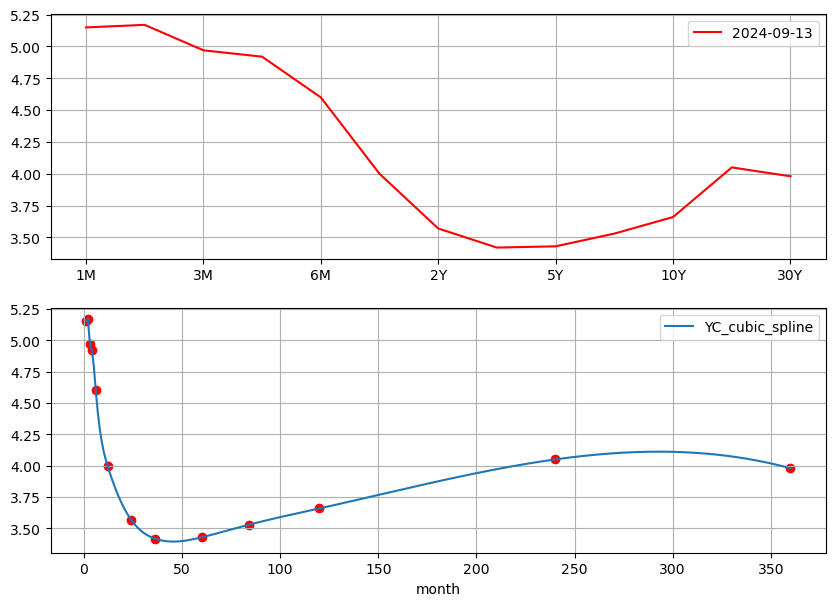

In [155]:
from scipy.interpolate import interp1d, CubicSpline
########################################################################################
## Step 1 : Get historical spot risk free Yield Curves (treasury) + Interpolation  
########################################################################################

# # scrap data from "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2024"
# L_df = []
# for y in range(2000, 2025):
#     url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=%i"%y
#     print(url)
#     tables = pd.read_html(url)
#     col_keep = ['Date','1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr', '10 Yr', '20 Yr', '30 Yr']
#     df_temp = tables[0][['Date','1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr', '10 Yr', '20 Yr', '30 Yr']]
#     df_temp.columns = ['date', '1M', '2M', '3M', '4M', '6M', '1Y', '2Y','3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
#     L_df.append(df_temp)

# df_all = pd.concat(L_df, axis=0)
# df_all.date = pd.to_datetime(df_all.date)
# df_all.sort_values(by='date')

# os.chdir('/Users/joshuakaji/Desktop/freelance/Interview preparation/CCR')
# df.to_pickle('treasury_spot_YC.pk')

# df = pd.read_pickle('treasury_spot_YC.pk')

########################################################################################
## Step 2 : interpolate vis cubic spline methode to fill in missing months 
########################################################################################

fig, ax = plt.subplots(2, 1, figsize=(10, 7)) 
def convert_to_months(period):
    if period.endswith('M'):
        return int(period[:-1])
    elif period.endswith('Y'):
        return int(period[:-1]) * 12

df = pd.read_pickle('treasury_spot_YC.pk')

YC_date = ['2024-09-13']
YC = df.loc[df.date.isin(YC_date)].drop(columns=['date']).T
YC.columns = YC_date 
YC.plot(ax=ax[0], grid = True, color='r')

# convert to months
YC_months = copy.deepcopy(YC)
YC_months.index =  YC_months.index.map(convert_to_months)
YC_months.index.rename('months', inplace =True)

# Perform cubic spline interpolation
cubic_spline_interp = CubicSpline(YC_months.index, YC_months.iloc[:, 0])
# fill in missing months
months_fine = np.arange(1, 361)
# Interpolate values
cubic_spline_yields = cubic_spline_interp(months_fine)

YC_months_CB = pd.DataFrame({'month': months_fine, 'YC_cubic_spline': cubic_spline_yields})

# plot YC after interpolation
YC_months_CB.set_index('month').plot(grid =True, ax = ax[1])
# plot YC scatter (without interpolation)
ax[1].scatter(x=YC_months.index, y=YC_months.iloc[:, 0], marker='o', color='red')

ax[1].grid(True)
plt.show()

In [156]:
########################################################################################
## Swap valuation (simplified CF structure : synchronized payment dates of float and fixed legs)
########################################################################################


YC = YC_months_CB.set_index('month')/100

# T in years, YC in monthly increments
def get_zcb(T): #ZCB valued at t=0
    if T==0:
        return 1
    month_position = int(T*12)
    return 1/(1 + YC.loc[month_position].values[0])**T

# t1 and t2 in years
def get_fwd_rate(t1, t2): #ZCB valued at t=0
    return (get_zcb(t1)/get_zcb(t2) - 1)/(t2 - t1)

def calculate_swap_value(N, T, K, freq = 0.5):
    dt = freq
    if T%dt != 0:
        raise ValueError("swap pricing is not defined for those parameters")
    NT = int(T//dt)
    mtm = sum([N * dt * get_zcb(n*dt) * (get_fwd_rate((n-1)*dt, n*dt) - K) for n in range(1, NT)])
    return mtm 
    
# 10Y swap with, with semi annual payoffs, K
#N=1e6
T = 10
K = 0.04
ir_swap_mtm = calculate_swap_value(1e6, T, K, freq = 0.5)
print("MtM of %i Year Swap with Fixed rate %.1f%%, with semi-annual payoffs and 1MEUR Notional : %i€"%(T, K*100, ir_swap_mtm))
T = 10
K = 0.03
ir_swap_mtm = calculate_swap_value(1e6, T, K, freq = 0.5)
print("MtM of %i Year Swap with Fixed rate %.1f%%, with semi-annual payoffs and 1MEUR Notional : %i€"%(T, K*100, ir_swap_mtm))


MtM of 10 Year Swap with Fixed rate 4.0%, with semi-annual payoffs and 1MEUR Notional : -32875€
MtM of 10 Year Swap with Fixed rate 3.0%, with semi-annual payoffs and 1MEUR Notional : 47328€


### <a id="section7"></a>  2.2) IR Forward Starting Swap
An interest rate forward swap is a swap that starts at a later date (as oposed to immediately in the case of a regular swap).<br><br>
<u>Delta adjustment</u>:
Just like a regular swap, the payoff is linear with respect to the interest rate term structure. The supervisory delta will be either -1 or +1 (repectively if short or long on floating rate)
<br>
<u>Time period parameters : Mi, Si, Ei, Ti</u>:<br>
- The underlying swap (from which cash flows materialize) referenced by the contract starts at the forward start date and lasts untill maturity of the swap, hence:
    - Si = forward start date<br>
    - Ei = forward start date + maturity of the referenced swap<br>
- The contract is active untill the last payment of the referenced swap hence Mi = forward start date + maturity of the referenced swap.<br>
- like a regular swap, there is no optionality in a forward IR swap hence Ti = NaN<br>

<u>MtM of the contract</u>:<br>
Valuation of a forward swap position is similar to that of a regular swap. Because the cash flows of the variable leg occur at a later time, the forward rates shifted accordingly. The terms of the discount fators used for  actualizing the cash flows of both fixed and floating legs are also shifted to account for cash flows occuring later.

<details>
  <summary> swap payments (floating vs fixed legs) </summary>
  <img src="screenshots/Fwd_start_swap_CF_structure.png" alt="image"  width="600" />
</details>



In [157]:

class fwdSwap(IRInstrument):
    def __init__(self, fwd_start, T, N, size, ccy):
        Mi, Si = fwd_start+T, fwd_start
        Ei, Ti, trd_N = fwd_start+T, np.nan, N
        self.T = T
        value = calculate_fwd_swap_value()
        IRInstrument.__init__(self, Mi, Si, Ei, Ti, size, trd_N, ccy, value)
    def __str__(self):
        res = "%s-year interest rate swap, forward starting in %s years" % (str(self.T), str(self.Si))
        return res + position_to_str(self.size)

def calculate_fwd_swap_value(N,T_fwd_start, T_swap, K, freq = 0.5):
    dt = freq
    if T_swap%dt != 0:
        raise ValueError("fwd swap pricing is not defined for those parameters")
    NT = int(T_swap//dt)
    mtm = sum([N * dt * get_zcb(n*dt+T_fwd_start) * (get_fwd_rate((n-1)*dt+T_fwd_start, n*dt+T_fwd_start) - K) for n in range(1, NT)])
    return mtm 

# 10Y swap, forward starting in 5 years with, with semi annual payoffs
T_fwd = 10
T = 10
K = 0.04
ir_fwd_swap_mtm = calculate_fwd_swap_value(1e6, T_fwd, T, K, freq = 0.5)
print("MtM of %i Year Swap with Fixed rate %.1f%%, forward starting in %i Years with semi-annual payoffs and 1MEUR Notional : %i€"%(T, K*100, T_fwd, ir_fwd_swap_mtm))
ir_swap_mtm = calculate_swap_value(1e6, T, K, freq = 0.5)
print("MtM of %i Year Swap with Fixed rate %.1f%%, with semi-annual payoffs and 1MEUR Notional : %i€"%(T, K*100, ir_swap_mtm))


MtM of 10 Year Swap with Fixed rate 4.0%, forward starting in 10 Years with semi-annual payoffs and 1MEUR Notional : 19828€
MtM of 10 Year Swap with Fixed rate 4.0%, with semi-annual payoffs and 1MEUR Notional : -32875€


### <a id="section8"></a>  2.3) IR Swaption (ie: call on swap)

An interest rate swaption is a call option on a swap contract that starts at exercice date with all parametors specified beforehand (at inception of the swaption contract). The option holder has the right at exercise date to enter into the swap. <br><br>
<u>Delta adjustment</u>:<br>
Since there is optionailty in a swaption, the supervisory delta adjustment will be calculated according to [52.40].<br>
The parametors required in the formula phi(d1) are the following:
- Pi = market swap rate prevailing at current time (ie: fixed rate at which the swap value is zero)
- Ki = the fixed rate specified in the swaption contract
- σi = the supervisory volatility specified in [52.72] (50% across all IR underlyings)
- Ti = the exercise date of the contract

<br><br>
<u>Time period parameters : Mi, Si, Ei, Ti</u>:<br>
- The underlying swap referenced by the contract starts at exercise date and lasts until maturity of the swap, hence:
    - Si = exercise date Ti<br>
    - Ei = exercise date Ti + maturity of the referenced swap<br>
- Assuming the contract is physically settled, will be active untill the last payment of the referenced swap hence Mi = exercise date Ti + maturity of the referenced swap.<br>
- Ti = the exercise date <br>

<u>Note</u>: in the case of a cash settled swaption, the swaption contract would only be active until exercise date Ti, hence Mi = exercise date Ti.<br><br>
<u>MtM of the contract</u>:<br>
Valuation of a swaption requires the used of the Black model. [... TODO ...]

In [158]:
class euroSwaption(IRInstrument):
    def __init__(self, T_exercise, T, N, r0, K, size, ccy):
        Mi, Si = T_exercise, T_exercise
        Ei, Ti, trd_N = T_exercise+T, T_exercise, N
        self.T = T
        self.r0, self.K = r0, K
        value = calculate_euro_swaption_value()
        IRInstrument.__init__(self, Mi, Si, Ei, Ti, size, trd_N, ccy, value)

    def __str__(self):
        res = "Cash-settled European swaption referencing %s-year interest rate swap with exercise date in %s years" % (str(self.T), str(self.Si))
        return res + position_to_str(self.size)
    
    def set_delta(self): # swaptions is a call on a swap
        # supervisory volatility for IR is 50%
        sigma = 0.5
        self.delta = get_delta_call(self.r0, self.K, sigma, self.Ti) * self.size

def calculate_euro_swaption_value():
    # todo 
    return np.nan

# Cash-settled European swaption referencing 5-year interest rate swap with exercise date in 6 months
r0, K = 0.05, 0.05
euro_swaption1 = euroSwaption(0.5, 5, 100e3, r0-0.01, K, 1, "USD")
euro_swaption2 = euroSwaption(0.5, 10, 100e3, r0, K, 1, "EUR")
euro_swaption3 = euroSwaption(0.5, 10, 100e3, r0+0.01, K, 1, "JPY")

print(euro_swaption1)
print(euro_swaption2)
print(euro_swaption3)

Cash-settled European swaption referencing 5-year interest rate swap with exercise date in 0.5 years // long 1
Cash-settled European swaption referencing 10-year interest rate swap with exercise date in 0.5 years // long 1
Cash-settled European swaption referencing 10-year interest rate swap with exercise date in 0.5 years // long 1


## <a id="section9"></a> 3) FX instruments

<u>Specificities for FX intruments</u>:<br>
<details>
  <summary>[52.58] : for FX instruments, there are no buckets within hedging sets. Full ofset of effective notional Di is permited within HS </summary>
  <img src="screenshots/52.58.png" alt="image"  width="600" />
</details><br>

<details>
  <summary>[52.59 (2)] : for FX instruments, hedging sets correspond to currency pairs (eg: EUR/USD) </summary>
  <img src="screenshots/52.59 (2).png" alt="image"  width="600" />
</details>
<br>
<details>
  <summary>[52.35] : adjusted notional di for FX</summary>
  <img src="screenshots/52.35.png" alt="image"  width="600" />
</details>
<br>

For valuation purposes, we define:
- spot rates of currency pairs
- IR yield by currency. We assume flat yield curves for simplicity.<br>
- implied volatilities for different currency pairs <br>

<u>Note</u>: the implied volatilities will only be used for the computation of the value of the position. For the purpose of calculating the supervisory delta adjustment, the supervisory volatility in table [52.72] must be used (ie: 15%). 



In [159]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 14 14:06:52 2024

@author: joshuakaji
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os 
os.chdir('/Users/joshuakaji/Desktop/freelance/Interview preparation/CCR')
# import parent classes
from SA_CCR_common import instrument, assetClass, hedgingSet, bucket
# import function 
from SA_CCR_common import position_to_str, get_delta_call
import itertools 

# assuming flat YCs
currency_yields = {
    "EUR": 0.03664,
    "USD": 0.0498,
    "GBP": 0.0535,
    "JPY": 0.0045
}

# fx spot Implied volatilities 
currency_volatilities = {
    "EUR/USD": 0.065,
    "EUR/GBP": 0.072,
    "EUR/JPY": 0.080,
    "USD/JPY": 0.080,
    "USD/GBP": 0.070,
    "USD/EUR": 0.065,
    "GBP/JPY": 0.085,
    "GBP/USD": 0.070,
    "GBP/EUR": 0.072
}

currency_spots = {
    "EUR/USD": 1.2000,
    "GBP/USD": 1.3500,
    "USD/JPY": 110.50,  
    "EUR/GBP": 0.8900,
    "EUR/JPY": 132.00,
    "GBP/JPY": 149.50
}

class FXInstrument(instrument):
    # trd_N must be in domestic currency
    def __init__(self, Mi, Si, Ei, Ti, size, trd_N, ccy_pair, value): 
        # di = trade Notional
        instrument.__init__(self, Mi, Si, Ei, Ti, size, ccy_pair, value)
        # [52.35] adjusted notional for FX
        self.di = trd_N


### <a id="section10"></a>  3.1) FX Forward

An FX Forward is a contract between two parties to exchange a specified amount of one currency for another at a predetermined exchange rate, on a future date. <br><br>
The parametors of an FX forward are:
- currency pair : BASE/QUOTE (eg: USD/EURO); this corresopnds to the hedging set of the instrument
- T : the settlement date of the FX forward contract
- N : the notional (denominated in the BASE currency
- the forward exchange rate fwd_fx_rate expressed in QUOTE/BASE (ie: indicating the price of 1 unit of the base currency in terms of the quote currency)

With the parametors above, we will recieve N amount of BASE currency in exchange for N * fwd_fx_rate amount of QUOTE currency.

<u>Hedging set allocation</u>:<br> 
The instrument will be allocated to hedging set BASE/QUOTE<br><br>
<u>Delta adjustment</u>:<br>
Since there is no optionality, the delta adjustment will be +1 or -1 depending whether we are long or short on the hedging set currency pair<br>
<br>
<u>Time period parameters : Mi, Si, Ei, Ti</u>:<br>
- Si = term of the contract<br>
- Ei = term of the contract<br>
- Mi = term of the contract<br>
- Ti = NaN since there is no optionality<br>

<u>MtM of the contract</u>:<br>
Pricing the FX forward simply requires discounting the future cash flows with the corresponding discount factors (eg: to discount a cash flow occuring at time T, we multiply the cash flow by the ZCB of the same currency, with maturity T). The value of the forward contract will be denominated in the QUOTE currency.<br>

<u>Note</u>: If the quote currency is not the domestic (reporting) currency of the bank, it must be converted via the current spot exchange rate.



In [161]:

class fxForward(FXInstrument):
    def __init__(self, T_settlement , N, ccy_base, ccy_quote, fx_spot, fwd_rate, size): 
        Mi, Si, Ei = T_settlement , T_settlement , T_settlement 
        Ti = np.nan
        # convert notional to domestic currency
        trd_N = fx_convert(N, ccy_base)
        self.ccy_base = ccy_base
        self.T_settlement  = T_settlement 
        self.ccy_quote = ccy_quote
        self.fx_spot = fx_spot
        self.fwd_rate = fwd_rate
        self.N = N # notional in base currency
        ccy_pair = ccy_base + '/' + ccy_quote
        # for colculating Replacement Cost (RC)
        yld_base, yld_quote = currency_yields[ccy_base], currency_yields[ccy_quote]
        # calculate value of contract in quote currency
        value = size * calculate_forward_value(N, fx_spot, yld_base, yld_quote, fwd_rate, T_settlement)
        # convert value to EUR
        value = fx_convert(value, ccy_quote)
        FXInstrument.__init__(self, Mi, Si, Ei, Ti, size, trd_N, ccy_pair, value)

    def __str__(self):
        res = "FX FWD to buy %i %s (base) against %s (quote) at forward rate %s in %.1f years" \
            %(self.N, self.ccy_base, self.ccy_quote, self.fwd_rate, self.T_settlement)
        return res + position_to_str(self.size)

def calculate_forward_value(N, fx_spot, yld_base, yld_quote, fwd_rate, T):
    # FX FWD : buy N base against quote at fwd_rate with settlement in T years 
    # fwd_market_rate is the rate at which the contract value is zero
    fwd_market_rate = fx_spot * ((1 + yld_quote * T) / (1 + yld_base * T))
    
    # Calculate the value of the forward contract
    # discount with quote ccy yield since payout is in the quote ccy
    forward_value = N * (fwd_market_rate - fwd_rate) / (1 + yld_quote * T)
    return forward_value


# convert Notional of to currency EUR
def fx_convert(N, ccy_from, ccy_to='EUR'):    
    fx_rate = ccy_from+'/'+ccy_to
    fx_rate_inv = ccy_to+'/'+ccy_from
    if fx_rate in currency_spots.keys():
        return N*currency_spots[fx_rate]
    elif fx_rate_inv in currency_spots.keys():
        return N * 1/currency_spots[fx_rate_inv]
    elif ccy_from==ccy_to:
        return N
    else:
        raise ValueError('ccy pair not found in function fx_convert')

# FX forward to buy 100k EUR/USD (buy 100K euros for USD) at fixed fwd_rate
# base/quote = EUR/USD. Notional quoted in base currency

# common params 
T_settlement = 0.5
# Notional in BASE currency
size, N = 1, 100e3

ccy_base, ccy_quote = 'EUR', 'USD'
fx_spot = currency_spots[ccy_base+'/'+ccy_quote]
fwd_rate = fx_spot
fx_fwd1 = fxForward(T_settlement, N, ccy_base, ccy_quote, fx_spot, fwd_rate, size)

ccy_base, ccy_quote = 'EUR', 'GBP'
fx_spot = currency_spots[ccy_base+'/'+ccy_quote]
fwd_rate = fx_spot
fx_fwd2 = fxForward(T_settlement, N, ccy_base, ccy_quote, fx_spot, fwd_rate, size)

ccy_base, ccy_quote = 'GBP', 'JPY'
fx_spot = currency_spots[ccy_base+'/'+ccy_quote]
fwd_rate = fx_spot
fx_fwd3 = fxForward(T_settlement, N, ccy_base, ccy_quote, fx_spot, fwd_rate, size)

print(fx_fwd1)
print(fx_fwd2)
print(fx_fwd3)


FX FWD to buy 100000 EUR (base) against USD (quote) at forward rate 1.2 in 0.5 years // long 1
FX FWD to buy 100000 EUR (base) against GBP (quote) at forward rate 0.89 in 0.5 years // long 1
FX FWD to buy 100000 GBP (base) against JPY (quote) at forward rate 149.5 in 0.5 years // long 1


### <a id="section11"></a>  3.2) FX Call (European)

An FX Call option gives the holder the right, at exercise date, to buy a specific amount of BASE currency at a predetermined exchange rate (strike) of the QUOTE currency. <br><br>

<u>Delta adjustment</u>:<br>
Since there is optionailty in a call, the supervisory delta adjustment will be calculated according to [52.40].<br>
The parametors required in the formula phi(d1) are the following:
- Pi = the spot market exchange rate 
- Ki = the strike exchange rate of the contract
- σi = the supervisory volatility specified in [52.72] (15% for FX instruements)
- Ti = the exercise date of the contract

<br>
<u>Note</u>: Just like for the FX Forward, the notional is in BASE currency, the value of the option in QUOTE currency and the strike in QUOTE/BASE.
<br>

<u>Time period parameters : Mi, Si, Ei, Ti</u>:<br>
- Si = exercise date Ti<br>
- Ei = exercise date Ti<br>
- The contract will be active untill exercise date hence Mi = exercise date Ti<br>
- Ti = the exercise date <br>

<u>MtM of the contract</u>:<br>
Valuation of an FX call requires the use the Garman-Kohlhagen model. The Garman-Kohlhagen model extends the Black-Scholes model by incorporating two interest rates: one for the domestic currency and one for the foreign currency.
[... TODO : PROOF...]

In [162]:

# european call (with unique exercise date)
class fxCall(FXInstrument):
    def __init__(self, T_exercise, N, fx_pair, fx_spot, stike, size): 
        Mi, Si, Ei = T_exercise , T_exercise , T_exercise 
        Ti = T_exercise
        ccy_base, ccy_quote = fx_pair.split('/')
        self.ccy_base = ccy_base
        self.ccy_quote = ccy_quote
        # convert notional to reporting currency
        trd_N = fx_convert(N, ccy_base, 'EUR')
        self.T_exercise  = T_exercise 
        self.fx_spot = fx_spot
        self.stike = stike
        self.fx_pair = fx_pair 
        self.N = N # notional in base currency
        # for calculating Replacement Cost (RC)
        yld_base, yld_quote = currency_yields[ccy_base], currency_yields[ccy_quote]
        sigma = currency_volatilities[fx_pair]
        # calculate value of contract in quote currency
        value = size * calculate_fx_call(fx_spot, stike, T_exercise, yld_quote, yld_base, sigma, N)
        # convert value to EUR
        value = fx_convert(value, ccy_quote)
        FXInstrument.__init__(self, Mi, Si, Ei, Ti, size, trd_N, fx_pair, value)
    
    def set_delta(self):
        # [52.72] supervisory Implied vol for FX = 0.15
        sigma = 0.15
        self.delta = get_delta_call(self.fx_spot, self.stike, sigma, self.Ti) * self.size
        
        
    def __str__(self):
        res = "FX call on %s with strike %.2f with exercise in %.1f years on (N = %.0f %s" \
            %(self.fx_pair, self.stike, self.T_exercise, self.N, self.ccy_base)
        return res + position_to_str(self.size)
    
def calculate_fx_call(S0, K, T, r_domestic, r_foreign, sigma, N):
    # domestic is quote ccy, foreign is base ccy
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + (r_domestic - r_foreign + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate the value of the call option
    call_value = (S0 * np.exp(-r_foreign * T) * norm.cdf(d1)) - K * np.exp(-r_domestic * T) * norm.cdf(d2)
    
    return N * call_value

# common params
N = 100e3
T_exercise=3/12
size = 1

fx_pair='EUR/USD'
fx_spot = currency_spots[fx_pair]
# set strick as 5% OTM
stike = fx_spot*0.95
sigma = currency_volatilities[fx_pair]
# call on EUR/USD with exercise date in 3 months, 5% out of the money
fx_call1 = fxCall(T_exercise, N, fx_pair, fx_spot, stike, size)
print(fx_call1)

fx_pair = 'EUR/GBP'
fx_spot = currency_spots[fx_pair]
stike = fx_spot*0.95
sigma = currency_volatilities[fx_pair]
fx_call2 = fxCall(T_exercise, N, fx_pair, fx_spot, stike, size)
print(fx_call2)


fx_pair = 'GBP/USD'
fx_spot = currency_spots[fx_pair]
# set strick as 5% OTM
stike = fx_spot*0.95
sigma = currency_volatilities[fx_pair]
fx_call3 = fxCall(T_exercise, N, fx_pair, fx_spot, stike, size)
print(fx_call3)


FX call on EUR/USD with strike 1.14 with exercise in 0.2 years on (N = 100000 EUR // long 1
FX call on EUR/GBP with strike 0.85 with exercise in 0.2 years on (N = 100000 EUR // long 1
FX call on GBP/USD with strike 1.28 with exercise in 0.2 years on (N = 100000 GBP // long 1


## <a id="section12"></a> 4) Equity instruments

<u>Specificities for Equity intruments</u>:<br>

<details>
  <summary>[52.65] : for Equity instruments, hedging sets correspond to entities or indices (eg: TESLA, snp500) </summary>
  <img src="screenshots/52.59 (2).png" alt="image"  width="600" />
</details>
<br>

### <a id="section13"></a>  4.1) Equity Call (European)

<u>Delta adjustment</u>:<br>
Since there is optionality in a call, the supervisory delta adjustment will be calculated according to [52.40].<br>
<br>
<u>Time period parameters : Mi, Si, Ei, Ti</u>:<br>
- Mi = Si = Ti = Ei = Ti = exercise date 

<u>MtM of the contract</u>:<br>
Black and Scholes call formula

In [163]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 15 17:53:55 2024

@author: joshuakaji
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import os 
# import parent classes
from SA_CCR_common import instrument, assetClass, hedgingSet, bucket
# import function 
from SA_CCR_common import position_to_str, get_delta_call


class equityInstrument(instrument):
    def __init__(self, Mi, Si, Ei, Ti, size, hs, value, trd_N):
        instrument.__init__(self, Mi, Si, Ei, Ti, size, hs, value)
        self.di = trd_N

class euroCallEquity(equityInstrument):
    def __init__(self, S0, K, T, name, size, single_name = True):
        Mi = T
        Si = T
        Ei = T
        Ti = T
        hs = name
        self.K = K
        self.S0 = S0
        # TODO
        value = black_scholes_call(S0, sigma, K, T)
        hs = name
        # single name influences the volatility and systemic correlation factors 
        self.single_name = single_name
        equityInstrument.__init__(self, Mi, Si, Ei, Ti, size, hs, value, S0)
    def __str__(self):
        res = "euro call on %s with exercise date in %.1f years" %(self.hs, self.Ti)
        res += position_to_str(self.size)
        return res
    def set_delta(self):
        # [52.72] : supervisory vol for single names is 120%, 75% for index 
        sigma = 1.2 if self.single_name else 0.75
        self.delta = self.size * get_delta_call(self.S0, self.K, sigma, self.Ti)
        
# assume for simplicity that calls are always on 1 share
def black_scholes_call(S, sigma, K, T):
    r=YC_months_CB.set_index('month').loc[int(T*12)]
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0)) - (K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call_price

# european call option on underlying equity spot price maturing in 6 months 
S0 = 90
K = 100
T = 0.5
name = 'aapl'
single_name = True
euroCall1 = euroCallEquity(S0, K, T, name, 1, single_name)
name = 'tesla'
euroCall2 = euroCallEquity(S0, K, T, name, 2, single_name)

name = 'tesla'
euroCall3 = euroCallEquity(S0, K, T, name, -1, single_name)

name = 'snp500'
single_name = False
euroCall4 = euroCallEquity(S0, K, T, name, -2, single_name)

print(euroCall1)
print(euroCall2)
print(euroCall3)
print(euroCall4)

euro call on aapl with exercise date in 0.5 years // long 1
euro call on tesla with exercise date in 0.5 years // long 2
euro call on tesla with exercise date in 0.5 years // short 1
euro call on snp500 with exercise date in 0.5 years // short 2
